# 1) Descentes de gradient sans contraintes
-------------------------------------------


1-1) Soit la famille de fonction: $f(x, y) = \frac{x²}{2} + \frac{ay²}{2} ~\forall~ a \in [1; +\inf]$

Le nombre de conditionnement d'une fonction de cette famille est équivalent au nombre de conditionnement de sa Hessienne:

$H = \begin{pmatrix} 1 & 0 \\ 0 & a \end{pmatrix}$

On choisit d'utiliser la norme $l_2$ pour calculer le nombre de conditionnement de notre matrice.
Dans ce cadre, le nombre de conditionnement est égal à: $||H||_2 * ||H^{-1}||_2$

Dans notre cas, le nombre de conditionnement correspond à la plus grande valeur singulière divisée par la plus petite. Donc le nombre de conditionnement est $\frac{a}{1} = a$ avec $a \in [1; +\inf[$

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [6]:
def build_obj(a):
    def obj_func(x):
        return (x[0] ** 2)/2 + a*(x[1] ** 2)/2
    return obj_func


def build_derivative_obj(a):
    def derivative_obj(x):
        return x[0] + a*x[1]
    return derivative_obj

def gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None),
                     verbose=False):
    """Gradient Descent.
    
    Computes minimal value of a convex function and local minimum of none convex function.
    
    Args:
        x (ndarray): initial starting point for descent.
        ob_function: objective function of optimisation problem, has input ndarray and outputs float.
        d_direction: function computing descent direction, outputs ndarray.
        rate: function computing learning rate, outputs float.
        decay_function: function computing decay, outputs float.
        tolerance (float): slack tolerance.
        max_iter (int): upper bound on number of iterations.      
        plot_f: plotting function for iteration points.
         
    Output:
        (int, int) minimizer, minimal value.
        
    """
    n_iter = 0
    decay = tolerance + 10  # Make sure that we get into first loop
    y = ob_function(x)
    while decay > tolerance and n_iter < max_iter:
        x = x - rate(ob_function, n_iter) * d_direction(x)
        tmp_y = ob_function(x)
        decay = decay_function(y, tmp_y)
        y = tmp_y
        n_iter += 1
        plot_f(x, y)
    if verbose:
        print(' Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}.'.format(n_iter, x.flatten(), y[0], decay))
    return ((x, y), n_iter) if decay <= tolerance else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)

In [47]:
def eval_nb_iterations(step, set_size=30, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)
        derivative_obj = build_derivative_obj(a)

        start = np.array([[1], [1]], dtype=float)
        P, n_iter = gradient_descent(start, obj, derivative_obj, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        count+=1

    plt.plot(iterations, 'r', conditioning, 'b')
    plt.show()

Pour un pas de 0.01

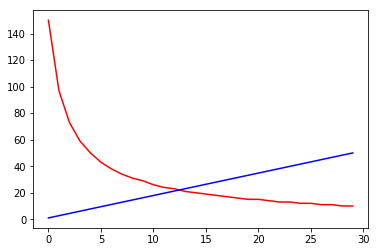

In [49]:
eval_nb_iterations(0.01)

Pour un pas de 0.02

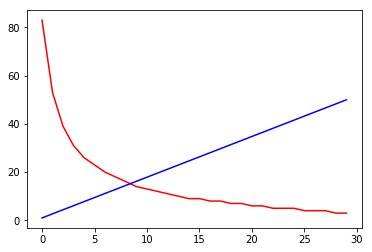

In [51]:
eval_nb_iterations(0.02)

Pour un pas de 0.03

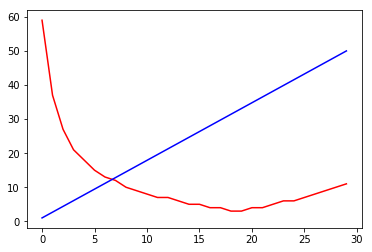

In [53]:
eval_nb_iterations(0.03)

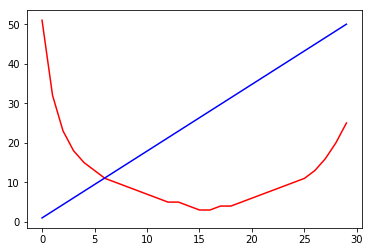

In [58]:
eval_nb_iterations(0.035)